Imports

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit_ibm_provider import IBMProvider
import numpy as np


Quantum Teleportation Protocol

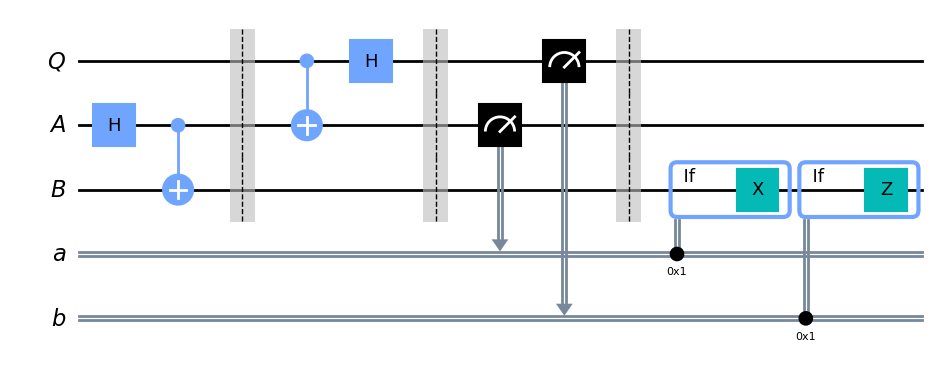

In [23]:
# Set up registers and circuit
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw("mpl"))

Generate random unitary gate

In [24]:
random_gate = UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi,
)

display(random_gate.to_matrix())

array([[ 0.79586582+0.j        , -0.51972132-0.31062414j],
       [ 0.56542486+0.21654637j,  0.49193517+0.62562144j]])

Test circuit applying random gate to Q

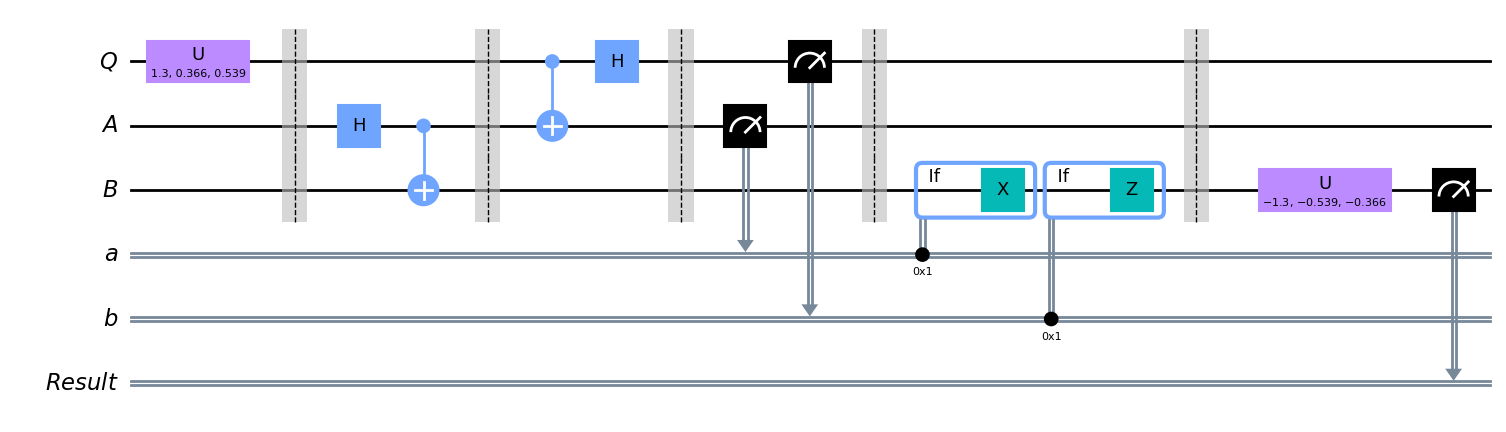

In [25]:
# Create a new circuit including the same bits and qubits
# used in the teleportation protocol

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# apply the random gate to Q
test.append(random_gate, qubit)
test.barrier()

# append the teleportation protocol
test = test.compose(protocol)
test.barrier()

# apply the inverse of the random gate to B and measure

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw("mpl"))

Run simulator and plot results

c:\Users\caleb\anaconda3\envs\qiskit-stable\Lib\site-packages\qiskit_ibm_provider\ibm_backend.py:459: UserWarning: The backend ibm_osaka does not support dynamic circuits.
  warnings.warn(f"The backend {self.name} does not support dynamic circuits.")


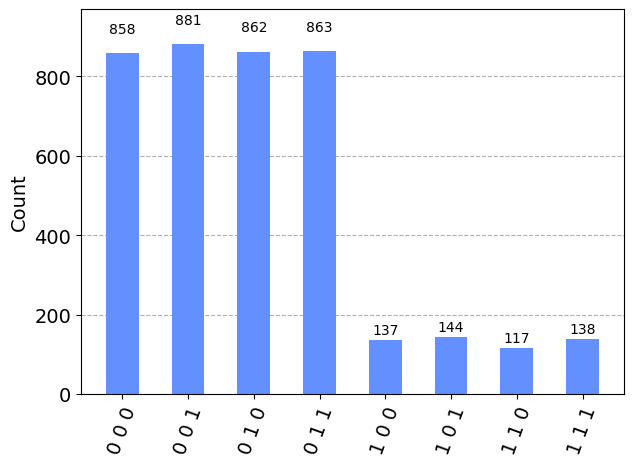

In [26]:
provider = IBMProvider()
backend = provider.get_backend("ibm_osaka")
transpiled = transpile(test, backend=backend)
job = backend.run(transpiled)
retrieved_job = provider.backend.retrieve_job(job.job_id())
statistics = retrieved_job.result().get_counts()
display(plot_histogram(statistics))

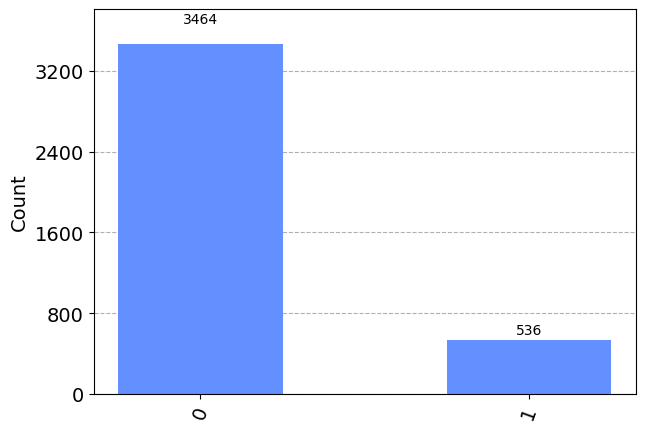

In [27]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

Superdense Coding Protocol

In [4]:
# classical bits to be sent
c = "1"
d = "0"

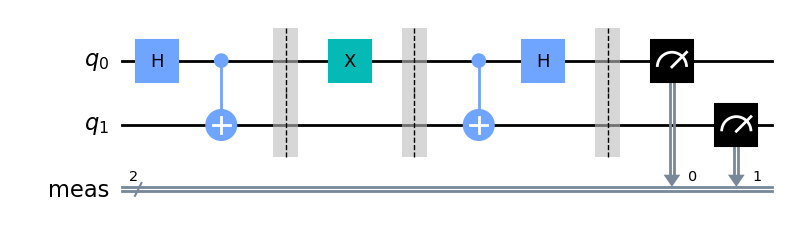

In [7]:
protocol = QuantumCircuit(2)

# prepare the ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw("mpl"))